# GIN Link Prediction on SemanticGraph

This notebook trains a Graph Isomorphism Network (GIN) for link prediction on SemanticGraph datasets.

**Instructions:**
1. Upload your `SemanticGraph_*.pkl` file to Colab (same folder as notebook)
2. Run all cells sequentially
3. Adjust hyperparameters in the "Configuration" section as needed


## 1. Setup and Imports


In [1]:
# Check GPU availability
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")


PyTorch version: 2.8.0+cu126
CUDA available: True
GPU: Tesla T4


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pickle
import random
import time
from datetime import date, datetime
import matplotlib.pyplot as plt
from typing import Optional


## 2. Configuration


In [3]:
# ============================================
# CONFIGURATION - Adjust these parameters
# ============================================

# Dataset path - UPDATE THIS!
# Option 1: Local upload (for small files)
# DATASET_PATH = "SemanticGraph_delta_1_cutoff_25_minedge_1.pkl"

# Option 2: Google Drive (recommended for large files)
DATASET_PATH = "/kaggle/input/science4cast/Science4Cast_18datasets/SemanticGraph_delta_1_cutoff_25_minedge_3.pkl"

# Model hyperparameters (REDUCED for memory efficiency!)
HIDDEN_DIM = 32       # Hidden dimension for GIN (reduced from 64)
NUM_LAYERS = 2        # Number of GIN layers (reduced from 3)
EDGE_HIDDEN = 32      # Hidden dimension for edge decoder (reduced from 64)
DROPOUT = 0.5         # Dropout probability

# Training hyperparameters
EPOCHS = 10           # Number of training epochs
BATCH_SIZE = 1024     # Batch size (reduced from 2048)
LEARNING_RATE = 1e-3  # Learning rate
WEIGHT_DECAY = 1e-5   # L2 regularization

# Node features
USE_LEARNABLE_EMB = False  # Use learnable embeddings instead of ones
EMB_DIM = 16               # Embedding dimension (if USE_LEARNABLE_EMB=True)

# Other
TRAIN_RATIO = 0.9     # Ratio of data for training
SEED = 42             # Random seed

# Constants from original repository
NUM_OF_VERTICES = 64719

# Device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

# Clear GPU cache
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB total")

Using device: cuda
GPU Memory: 15.8 GB total


## 3. GIN Model Definition


In [4]:
class GINConvLayer(nn.Module):
    """
    Single GIN convolution layer.
    Aggregation: h_v^(k) = MLP^(k)((1 + eps) * h_v^(k-1) + sum_{u in N(v)} h_u^(k-1))
    """
    
    def __init__(self, in_dim: int, out_dim: int, eps: float = 0.0, train_eps: bool = True):
        super(GINConvLayer, self).__init__()
        
        self.mlp = nn.Sequential(
            nn.Linear(in_dim, out_dim),
            nn.BatchNorm1d(out_dim),
            nn.ReLU(),
            nn.Linear(out_dim, out_dim),
            nn.BatchNorm1d(out_dim),
        )
        
        if train_eps:
            self.eps = nn.Parameter(torch.tensor([eps]))
        else:
            self.register_buffer('eps', torch.tensor([eps]))
    
    def forward(self, x: torch.Tensor, edge_index: torch.Tensor) -> torch.Tensor:
        num_nodes = x.size(0)
        row, col = edge_index[0], edge_index[1]
        
        agg = torch.zeros(num_nodes, x.size(1), device=x.device, dtype=x.dtype)
        agg.index_add_(0, row, x[col])
        
        out = (1 + self.eps) * x + agg
        out = self.mlp(out)
        
        return out


class GINEncoder(nn.Module):
    """GIN encoder for obtaining node embeddings."""
    
    def __init__(self, in_dim: int, hidden_dim: int = 64, num_layers: int = 3,
                 eps: float = 0.0, train_eps: bool = True, dropout: float = 0.5):
        super(GINEncoder, self).__init__()
        
        self.num_layers = num_layers
        self.dropout = dropout
        
        self.convs = nn.ModuleList()
        self.convs.append(GINConvLayer(in_dim, hidden_dim, eps, train_eps))
        
        for _ in range(num_layers - 1):
            self.convs.append(GINConvLayer(hidden_dim, hidden_dim, eps, train_eps))
    
    def forward(self, x: torch.Tensor, edge_index: torch.Tensor) -> torch.Tensor:
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            if i < self.num_layers - 1:
                x = F.relu(x)
                x = F.dropout(x, p=self.dropout, training=self.training)
        return x


class MLPEdgeDecoder(nn.Module):
    """MLP decoder for edge prediction."""
    
    def __init__(self, hidden_dim: int = 64, edge_hidden: int = 64):
        super(MLPEdgeDecoder, self).__init__()
        
        self.mlp = nn.Sequential(
            nn.Linear(2 * hidden_dim, edge_hidden),
            nn.ReLU(),
            nn.Linear(edge_hidden, 1)
        )
    
    def forward(self, z: torch.Tensor, node_pairs: torch.Tensor) -> torch.Tensor:
        u_idx = node_pairs[:, 0]
        v_idx = node_pairs[:, 1]
        
        z_u = z[u_idx]
        z_v = z[v_idx]
        
        edge_feat = torch.cat([z_u, z_v], dim=1)
        logits = self.mlp(edge_feat).squeeze(-1)
        
        return logits


class GINLinkPredictor(nn.Module):
    """Complete model for GIN-based link prediction."""
    
    def __init__(self, in_dim: int, hidden_dim: int = 64, num_layers: int = 3,
                 edge_hidden: int = 64, eps: float = 0.0, train_eps: bool = True,
                 dropout: float = 0.5):
        super(GINLinkPredictor, self).__init__()
        
        self.encoder = GINEncoder(
            in_dim=in_dim, hidden_dim=hidden_dim, num_layers=num_layers,
            eps=eps, train_eps=train_eps, dropout=dropout
        )
        
        self.decoder = MLPEdgeDecoder(
            hidden_dim=hidden_dim, edge_hidden=edge_hidden
        )
    
    def forward(self, x: torch.Tensor, edge_index: torch.Tensor,
                node_pairs: torch.Tensor) -> torch.Tensor:
        z = self.encoder(x, edge_index)
        logits = self.decoder(z, node_pairs)
        return logits

print("Model classes defined successfully!")


Model classes defined successfully!


## 4. Utility Functions


In [5]:
def set_seed(seed: int):
    """Set random seed for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)


def load_semantic_graph(dataset_path: str):
    """Load SemanticGraph dataset from pickle file."""
    with open(dataset_path, "rb") as f:
        data = pickle.load(f)
    
    (full_dynamic_graph_sparse, unconnected_vertex_pairs, 
     unconnected_vertex_pairs_solution, year_start, years_delta, 
     vertex_degree_cutoff, min_edges) = data
    
    return (full_dynamic_graph_sparse, unconnected_vertex_pairs, 
            unconnected_vertex_pairs_solution, year_start, years_delta,
            vertex_degree_cutoff, min_edges)


def build_edge_index_from_graph(full_dynamic_graph_sparse: np.ndarray, 
                                 year_start: int,
                                 num_nodes: int = NUM_OF_VERTICES) -> torch.Tensor:
    """Build edge_index tensor from dynamic graph."""
    day_origin = date(1990, 1, 1)
    day_cutoff = date(year_start, 12, 31)
    cutoff_days = (day_cutoff - day_origin).days
    
    mask = full_dynamic_graph_sparse[:, 2] < cutoff_days
    edges = full_dynamic_graph_sparse[mask][:, :2]
    
    edge_list = []
    for v1, v2 in edges:
        edge_list.append([int(v1), int(v2)])
        edge_list.append([int(v2), int(v1)])
    
    edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()
    
    return edge_index


def prepare_data_splits(unconnected_vertex_pairs: np.ndarray,
                        unconnected_vertex_pairs_solution: np.ndarray,
                        train_ratio: float = 0.9,
                        seed: int = 42):
    """Split data into train/test sets with class balance preservation."""
    np.random.seed(seed)
    
    pos_idx = np.where(unconnected_vertex_pairs_solution == 1)[0]
    neg_idx = np.where(unconnected_vertex_pairs_solution == 0)[0]
    
    np.random.shuffle(pos_idx)
    np.random.shuffle(neg_idx)
    
    pos_train_size = int(len(pos_idx) * train_ratio)
    neg_train_size = int(len(neg_idx) * train_ratio)
    
    train_idx = np.concatenate([pos_idx[:pos_train_size], neg_idx[:neg_train_size]])
    test_idx = np.concatenate([pos_idx[pos_train_size:], neg_idx[neg_train_size:]])
    
    np.random.shuffle(train_idx)
    np.random.shuffle(test_idx)
    
    train_pairs = unconnected_vertex_pairs[train_idx]
    train_labels = unconnected_vertex_pairs_solution[train_idx]
    test_pairs = unconnected_vertex_pairs[test_idx]
    test_labels = unconnected_vertex_pairs_solution[test_idx]
    
    return train_pairs, train_labels, test_pairs, test_labels


def compute_auc(predictions: np.ndarray, labels: np.ndarray) -> float:
    """Compute AUC-ROC score."""
    sorted_idx = np.argsort(-predictions)
    labels_sorted = labels[sorted_idx]
    
    n_pos = np.sum(labels)
    n_neg = len(labels) - n_pos
    
    if n_pos == 0 or n_neg == 0:
        return 0.5
    
    rank_sum = 0.0
    fp = 0
    
    for label in labels_sorted:
        if label == 0:
            fp += 1
        else:
            rank_sum += fp
    
    auc = 1.0 - rank_sum / (n_pos * n_neg)
    return auc

print("Utility functions defined successfully!")


Utility functions defined successfully!


## 5. Training and Evaluation Functions


In [9]:
def train_epoch(model, x, edge_index, train_pairs, train_labels,
                optimizer, criterion, batch_size, device, embedding_layer=None):
    """Fast training - encoder fixed, only decoder trains."""
    model.train()
    
    num_samples = len(train_pairs)
    perm = torch.randperm(num_samples, device=device)
    train_pairs = train_pairs[perm]
    train_labels = train_labels[perm]
    
    total_loss = 0.0
    num_batches = 0
    
    # Compute embeddings ONCE per epoch (fast!)
    with torch.no_grad():
        if embedding_layer is not None:
            node_ids = torch.arange(NUM_OF_VERTICES, device=device)
            x_input = embedding_layer(node_ids)
        else:
            x_input = x
        z = model.encoder(x_input, edge_index)
    
    for i in range(0, num_samples, batch_size):
        batch_pairs = train_pairs[i:i+batch_size]
        batch_labels = train_labels[i:i+batch_size].float()
        
        optimizer.zero_grad()
        logits = model.decoder(z, batch_pairs)
        loss = criterion(logits, batch_labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        num_batches += 1
    
    return total_loss / num_batches


@torch.no_grad()
def evaluate(model, x, edge_index, test_pairs, test_labels,
             batch_size, device, embedding_layer=None):
    """Evaluate model on test set."""
    model.eval()
    
    if embedding_layer is not None:
        node_ids = torch.arange(NUM_OF_VERTICES, device=device)
        x_input = embedding_layer(node_ids)
    else:
        x_input = x
    
    z = model.encoder(x_input, edge_index)
    
    all_logits = []
    for i in range(0, len(test_pairs), batch_size):
        batch_pairs = test_pairs[i:i+batch_size]
        logits = model.decoder(z, batch_pairs)
        all_logits.append(logits.cpu())
    
    all_logits = torch.cat(all_logits, dim=0)
    predictions = all_logits.numpy()
    labels = test_labels.cpu().numpy()
    
    return compute_auc(predictions, labels), predictions

print("Training functions defined successfully!")

Training functions defined successfully!


## 6. Load Data


In [7]:
# Set seed
set_seed(SEED)

# Load dataset
print(f"Loading dataset: {DATASET_PATH}")
start_time = time.time()

(full_dynamic_graph_sparse, unconnected_vertex_pairs,
 unconnected_vertex_pairs_solution, year_start, years_delta,
 vertex_degree_cutoff, min_edges) = load_semantic_graph(DATASET_PATH)

print(f"\nDataset info:")
print(f"  year_start: {year_start}")
print(f"  years_delta: {years_delta}")
print(f"  vertex_degree_cutoff: {vertex_degree_cutoff}")
print(f"  min_edges: {min_edges}")
print(f"  num_vertex_pairs: {len(unconnected_vertex_pairs)}")
print(f"  positive_pairs: {sum(unconnected_vertex_pairs_solution)}")
print(f"  negative_pairs: {len(unconnected_vertex_pairs_solution) - sum(unconnected_vertex_pairs_solution)}")


Loading dataset: /kaggle/input/science4cast/Science4Cast_18datasets/SemanticGraph_delta_1_cutoff_25_minedge_1.pkl

Dataset info:
  year_start: 2019
  years_delta: 1
  vertex_degree_cutoff: 25
  min_edges: 1
  num_vertex_pairs: 10000000
  positive_pairs: 22713
  negative_pairs: 9977287


In [10]:
# Build edge_index
print("Building edge_index...")
edge_index = build_edge_index_from_graph(
    full_dynamic_graph_sparse, year_start, NUM_OF_VERTICES
)
print(f"  num_edges (directed): {edge_index.size(1)}")

# Prepare train/test splits
print("\nPreparing train/test splits...")
train_pairs, train_labels, test_pairs, test_labels = prepare_data_splits(
    unconnected_vertex_pairs, unconnected_vertex_pairs_solution,
    TRAIN_RATIO, SEED
)

print(f"  train_pairs: {len(train_pairs)}")
print(f"  train_positive: {sum(train_labels)}")
print(f"  test_pairs: {len(test_pairs)}")
print(f"  test_positive: {sum(test_labels)}")


Building edge_index...
  num_edges (directed): 35784704

Preparing train/test splits...
  train_pairs: 8999999
  train_positive: 20441
  test_pairs: 1000001
  test_positive: 2272


In [11]:
# Convert to tensors and move to device
print(f"\nMoving data to {DEVICE}...")

train_pairs = torch.tensor(train_pairs, dtype=torch.long, device=DEVICE)
train_labels = torch.tensor(train_labels, dtype=torch.long, device=DEVICE)
test_pairs = torch.tensor(test_pairs, dtype=torch.long, device=DEVICE)
test_labels = torch.tensor(test_labels, dtype=torch.long, device=DEVICE)
edge_index = edge_index.to(DEVICE)

# Create node features
print("Creating node features...")
if USE_LEARNABLE_EMB:
    x = None
    embedding_layer = nn.Embedding(NUM_OF_VERTICES, EMB_DIM).to(DEVICE)
    in_dim = EMB_DIM
    print(f"  Using learnable embeddings with dim={EMB_DIM}")
else:
    x = torch.ones(NUM_OF_VERTICES, 1, device=DEVICE)
    embedding_layer = None
    in_dim = 1
    print(f"  Using constant features (ones)")

load_time = time.time() - start_time
print(f"\nData loading completed in {load_time:.2f}s")



Moving data to cuda...
Creating node features...
  Using constant features (ones)

Data loading completed in 76.78s


## 7. Initialize Model


In [12]:
# Create model
print("Initializing model...")
model = GINLinkPredictor(
    in_dim=in_dim,
    hidden_dim=HIDDEN_DIM,
    num_layers=NUM_LAYERS,
    edge_hidden=EDGE_HIDDEN,
    dropout=DROPOUT
).to(DEVICE)

# Count parameters
num_params = sum(p.numel() for p in model.parameters())
if embedding_layer is not None:
    num_params += sum(p.numel() for p in embedding_layer.parameters())
print(f"  Total parameters: {num_params:,}")

# Optimizer and loss
params = list(model.parameters())
if embedding_layer is not None:
    params += list(embedding_layer.parameters())

optimizer = torch.optim.Adam(params, lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
criterion = nn.BCEWithLogitsLoss()

print(f"\nModel architecture:")
print(model)


Initializing model...
  Total parameters: 5,603

Model architecture:
GINLinkPredictor(
  (encoder): GINEncoder(
    (convs): ModuleList(
      (0): GINConvLayer(
        (mlp): Sequential(
          (0): Linear(in_features=1, out_features=32, bias=True)
          (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Linear(in_features=32, out_features=32, bias=True)
          (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (1): GINConvLayer(
        (mlp): Sequential(
          (0): Linear(in_features=32, out_features=32, bias=True)
          (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Linear(in_features=32, out_features=32, bias=True)
          (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
    )
  )
  (decoder): MLPEdgeDecode

## 8. Training


In [13]:
print("=" * 60)
print("Starting training...")
print("=" * 60)

best_auc = 0.0
best_epoch = 0
history = {'train_loss': [], 'train_auc': [], 'test_auc': []}

total_start = time.time()

for epoch in range(1, EPOCHS + 1):
    epoch_start = time.time()
    
    # Training
    train_loss = train_epoch(
        model, x, edge_index, train_pairs, train_labels,
        optimizer, criterion, BATCH_SIZE, DEVICE, embedding_layer
    )
    
    # Evaluation
    train_auc, _ = evaluate(
        model, x, edge_index, train_pairs, train_labels,
        BATCH_SIZE, DEVICE, embedding_layer
    )
    test_auc, _ = evaluate(
        model, x, edge_index, test_pairs, test_labels,
        BATCH_SIZE, DEVICE, embedding_layer
    )
    
    epoch_time = time.time() - epoch_start
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_auc'].append(train_auc)
    history['test_auc'].append(test_auc)
    
    if test_auc > best_auc:
        best_auc = test_auc
        best_epoch = epoch
    
    print(
        f"Epoch {epoch:3d}/{EPOCHS} | "
        f"Loss: {train_loss:.4f} | "
        f"Train AUC: {train_auc:.4f} | "
        f"Test AUC: {test_auc:.4f} | "
        f"Time: {epoch_time:.2f}s"
    )

total_time = time.time() - total_start
print("\n" + "=" * 60)
print("Training completed!")
print("=" * 60)
print(f"Total training time: {total_time:.2f}s")
print(f"Best Test AUC: {best_auc:.4f} (epoch {best_epoch})")


Starting training...
Epoch   1/10 | Loss: 0.0201 | Train AUC: 0.8834 | Test AUC: 0.8816 | Time: 16.32s
Epoch   2/10 | Loss: 0.0133 | Train AUC: 0.8805 | Test AUC: 0.8786 | Time: 15.35s
Epoch   3/10 | Loss: 0.0130 | Train AUC: 0.8845 | Test AUC: 0.8816 | Time: 15.36s
Epoch   4/10 | Loss: 0.0128 | Train AUC: 0.8788 | Test AUC: 0.8767 | Time: 15.42s
Epoch   5/10 | Loss: 0.0128 | Train AUC: 0.8800 | Test AUC: 0.8775 | Time: 15.27s
Epoch   6/10 | Loss: 0.0127 | Train AUC: 0.8795 | Test AUC: 0.8774 | Time: 15.47s
Epoch   7/10 | Loss: 0.0128 | Train AUC: 0.8817 | Test AUC: 0.8793 | Time: 15.23s
Epoch   8/10 | Loss: 0.0128 | Train AUC: 0.8822 | Test AUC: 0.8800 | Time: 15.22s
Epoch   9/10 | Loss: 0.0128 | Train AUC: 0.8822 | Test AUC: 0.8797 | Time: 15.43s
Epoch  10/10 | Loss: 0.0128 | Train AUC: 0.8819 | Test AUC: 0.8790 | Time: 15.27s

Training completed!
Total training time: 154.35s
Best Test AUC: 0.8816 (epoch 1)


## 9. Results Visualization


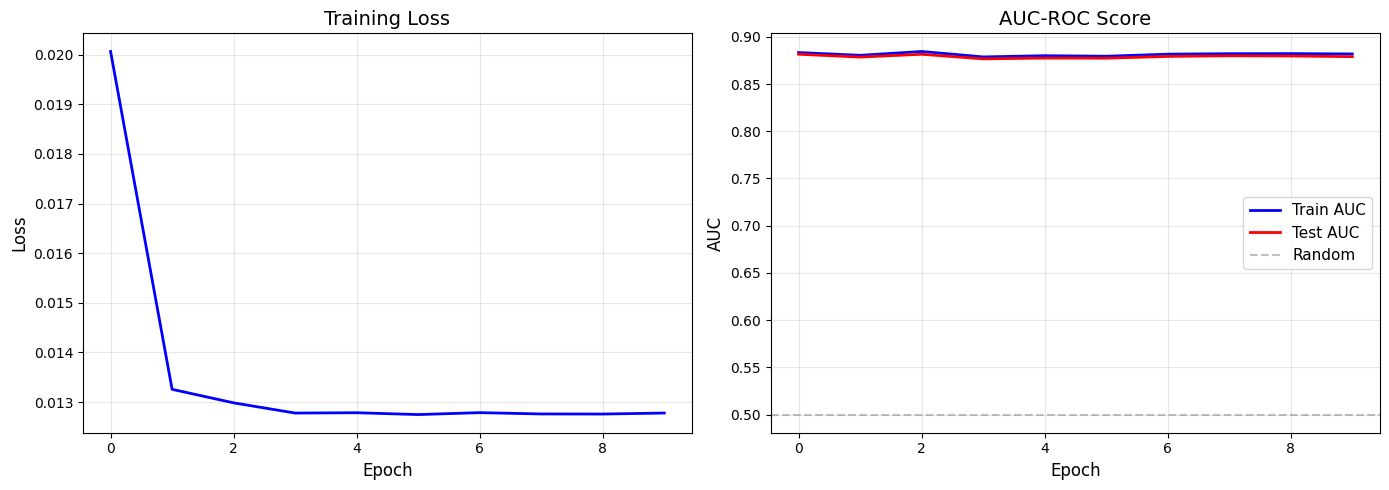

In [14]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
axes[0].plot(history['train_loss'], 'b-', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training Loss', fontsize=14)
axes[0].grid(True, alpha=0.3)

# AUC plot
axes[1].plot(history['train_auc'], 'b-', linewidth=2, label='Train AUC')
axes[1].plot(history['test_auc'], 'r-', linewidth=2, label='Test AUC')
axes[1].axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='Random')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('AUC', fontsize=12)
axes[1].set_title('AUC-ROC Score', fontsize=14)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 10. Final Summary


In [15]:
# Final evaluation
final_auc, final_predictions = evaluate(
    model, x, edge_index, test_pairs, test_labels,
    BATCH_SIZE, DEVICE, embedding_layer
)

print("=" * 60)
print("FINAL RESULTS")
print("=" * 60)
print(f"\nDataset: {DATASET_PATH}")
print(f"\nDataset parameters:")
print(f"  delta: {years_delta}")
print(f"  cutoff: {vertex_degree_cutoff}")
print(f"  min_edges: {min_edges}")
print(f"\nModel parameters:")
print(f"  hidden_dim: {HIDDEN_DIM}")
print(f"  num_layers: {NUM_LAYERS}")
print(f"  edge_hidden: {EDGE_HIDDEN}")
print(f"  dropout: {DROPOUT}")
print(f"\nTraining parameters:")
print(f"  epochs: {EPOCHS}")
print(f"  batch_size: {BATCH_SIZE}")
print(f"  learning_rate: {LEARNING_RATE}")
print(f"\n" + "-" * 40)
print(f"FINAL TEST AUC: {final_auc:.6f}")
print("-" * 40)


FINAL RESULTS

Dataset: /kaggle/input/science4cast/Science4Cast_18datasets/SemanticGraph_delta_1_cutoff_25_minedge_1.pkl

Dataset parameters:
  delta: 1
  cutoff: 25
  min_edges: 1

Model parameters:
  hidden_dim: 32
  num_layers: 2
  edge_hidden: 32
  dropout: 0.5

Training parameters:
  epochs: 10
  batch_size: 1024
  learning_rate: 0.001

----------------------------------------
FINAL TEST AUC: 0.879044
----------------------------------------
